In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid") # to set the default style for plots
pd.options.display.max_columns = None # to display all the columns
pd.options.display.max_rows = None # to display all rows

In [2]:
# Loading the dataset
df = pd.read_csv("ca_san_francisco_2020_04_01.csv", low_memory=False)

In [3]:
# Checking the first five rows of the dataframe (df)
df.head()

,raw_row_number,date,time,location,lat,lng,district,subject_age,subject_race,subject_sex,type,arrest_made,citation_issued,warning_issued,outcome,contraband_found,search_conducted,search_vehicle,search_basis,reason_for_stop,raw_search_vehicle_description,raw_result_of_contact_description
0,869921,2014-08-01,00:01:00,MASONIC AV & FELL ST,37.773004,-122.445873,NaN,NaN,asian/pacific islander,female,vehicular,False,False,True,warning,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Warning
1,869922,2014-08-01,00:01:00,GEARY&10TH AV,37.780898,-122.468586,NaN,NaN,black,male,vehicular,False,True,False,citation,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Citation
2,869923,2014-08-01,00:15:00,SUTTER N OCTAVIA ST,37.786919,-122.426718,NaN,NaN,hispanic,male,vehicular,False,True,False,citation,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Citation
3,869924,2014-08-01,00:18:00,3RD ST & DAVIDSON,37.746380,-122.392005,NaN,NaN,hispanic,male,vehicular,False,False,True,warning,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Warning
4,869925,2014-08-01,00:19:00,DIVISADERO ST. & BUSH ST.,37.786348,-122.440003,NaN,NaN,white,male,vehicular,False,True,False,citation,NaN,False,False,NaN,Mechanical or Non-Moving Violation (V.C.),No Search,Citation


# Data Cleaning

In [4]:
#checking if there are duplicates in the df
df.duplicated().sum()

0

In [5]:
#dropping columns that are not useful to the analysis
df.drop(['lat', 'lng'], axis = 'columns', inplace = True)

In [6]:
# Checking if there are empty values in the df
df.isna().sum()

raw_row_number                            0
date                                      0
time                                     35
location                                 43
district                              52187
subject_age                           58888
subject_race                              0
subject_sex                               0
type                                      0
arrest_made                               0
citation_issued                           0
warning_issued                            0
outcome                               15681
contraband_found                     851689
search_conducted                          0
search_vehicle                            0
search_basis                         851689
reason_for_stop                        2212
raw_search_vehicle_description            0
raw_result_of_contact_description         0
dtype: int64

In [7]:
df.shape

(905070, 20)

Removing the columns with over 850000 null values because they will have no influence on the analysis since they are virtually empty

In [8]:
df.drop(["contraband_found", 'search_basis'], axis = 'columns', inplace = True)

In [9]:
# Dropping the rows with empty values in the time and location columns
df.dropna(subset = ['time', 'location'], inplace = True)

Instead of dropping 58888 rows that contain missing values in subject_age column, I filled the missing values with the mean age of the respondents

In [10]:
df['subject_age'].fillna(df.subject_age.mean(), inplace = True)

Filling the missing values in outcome, district and reason_for_stop columns with "Not Disclosed" because the columns are important to the analysis and the number of rows with missing values are significant enough to be removed

In [11]:
df[["outcome", 'reason_for_stop', 'district']] = df[["outcome", 'reason_for_stop', 'district']].fillna("Not Stated")

In [12]:
# Checking for empty values again
df.isna().sum()

raw_row_number                       0
date                                 0
time                                 0
location                             0
district                             0
subject_age                          0
subject_race                         0
subject_sex                          0
type                                 0
arrest_made                          0
citation_issued                      0
warning_issued                       0
outcome                              0
search_conducted                     0
search_vehicle                       0
reason_for_stop                      0
raw_search_vehicle_description       0
raw_result_of_contact_description    0
dtype: int64

Correcting some discrepancies in the reason_for_stop column

In [13]:
df.reason_for_stop.value_counts()

Moving Violation                                                                                                                                                                            563063
Mechanical or Non-Moving Violation (V.C.)                                                                                                                                                   331441
MPC Violation                                                                                                                                                                                 3542
Not Stated                                                                                                                                                                                    2212
Traffic Collision                                                                                                                                                                             1343
BOLO/APB/Warrant         

From the above output, one can deduce that the dataset only has 7 unique reasons for stop. these unique reasons will be culled out from the dataframe

In [14]:
# Changing the name of the longest value name to an appropriate one
df['reason_for_stop'] = df.reason_for_stop.replace({"Mechanical or Non-Moving Violation (V.C.)":"Non-Moving Violation (V.C.)"})
# culling out the unique values
unique_reasons = ['Moving Violation', 'Non-Moving Violation (V.C.)', 'MPC Violation', 
                 'Traffic Collision', 'BOLO/APB/Warrant','DUI Check', 'Assistance to Motorist']
df = df[df.reason_for_stop.isin(unique_reasons)]
df.shape

(902563, 18)

The cleaned dataset now has 902563 entries, which is okay compared to the initial 905070 entries.

In [15]:
# Renaming some columns
df.rename(columns = {"reason_for_stop": "violation", "subject_sex": "gender", "subject_race": "race"}, inplace = True)

In [16]:
df.race.unique()

array(['asian/pacific islander', 'black', 'hispanic', 'white', 'other'],
      dtype=object)

In [17]:
# Changing the long value name in the output above to a shorter one
df['race'] = df.race.replace({"asian/pacific islander": "asian"})

## Concatenating the date and time columns and converting the new column to a datetime format

In [18]:
#Checking the types of all columns
df.dtypes

raw_row_number                        object
date                                  object
time                                  object
location                              object
district                              object
subject_age                          float64
race                                  object
gender                                object
type                                  object
arrest_made                             bool
citation_issued                         bool
warning_issued                          bool
outcome                               object
search_conducted                        bool
search_vehicle                          bool
violation                             object
raw_search_vehicle_description        object
raw_result_of_contact_description     object
dtype: object

In [19]:
date_combined = df.date.str.cat(df.time, sep = " ") #combining the columns
df['datetime'] = pd.to_datetime(date_combined) #to add a column named datetime which is a datetime datatype

In [20]:
# Saving the cleaned dataset. This will be used for dashboard creation using power bi
df.to_csv("cleaned_san_francisco_data.csv", index = False)

In [21]:
#setting the datetime as the index column
df.set_index("datetime", inplace = True)
df.index # to check the index

DatetimeIndex(['2014-08-01 00:01:00', '2014-08-01 00:01:00',
               '2014-08-01 00:15:00', '2014-08-01 00:18:00',
               '2014-08-01 00:19:00', '2014-08-01 00:30:00',
               '2014-08-01 00:30:00', '2014-08-01 00:35:00',
               '2014-08-01 01:00:00', '2014-08-01 01:00:00',
               ...
               '2014-10-31 23:35:00', '2014-10-31 23:40:00',
               '2014-10-31 23:41:00', '2014-10-31 23:45:00',
               '2014-10-31 23:46:00', '2014-10-31 23:47:00',
               '2014-10-31 23:48:00', '2014-10-31 23:49:00',
               '2014-10-31 23:50:00', '2014-10-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=902563, freq=None)

In [22]:
df.columns # to show that the datetime column is no longer part of the columns

Index(['raw_row_number', 'date', 'time', 'location', 'district', 'subject_age',
       'race', 'gender', 'type', 'arrest_made', 'citation_issued',
       'warning_issued', 'outcome', 'search_conducted', 'search_vehicle',
       'violation', 'raw_search_vehicle_description',
       'raw_result_of_contact_description'],
      dtype='object')

In [23]:
# showing ten random rows
df.sample(10)

,raw_row_number,date,time,location,district,subject_age,race,gender,type,arrest_made,citation_issued,warning_issued,outcome,search_conducted,search_vehicle,violation,raw_search_vehicle_description,raw_result_of_contact_description
datetime,,,,,,,,,,,,,,,,,,
2007-11-02 08:55:00,85644,2007-11-02,08:55:00,800 BLK O'FARRELL,E,40.000000,white,male,vehicular,False,True,False,citation,False,False,Moving Violation,No Search,Citation
2011-10-06 16:08:00,511577,2011-10-06,16:08:00,500 4TH AVE,G,25.000000,white,female,vehicular,False,False,True,warning,False,False,Moving Violation,No Search,Warning
2009-09-23 23:50:00,297903,2009-09-23,23:50:00,BAY/EMBARCADERO,A,39.000000,other,male,vehicular,False,True,False,citation,False,False,Moving Violation,No Search,Citation
2013-01-29 09:35:00,620736,2013-01-29,09:35:00,E/B LINCLN/34,I,25.000000,white,male,vehicular,False,True,False,citation,False,False,Non-Moving Violation (V.C.),No Search,Citation
2008-03-11 18:40:00,125833,2008-03-11,18:40:00,6TH/HOWARD/STSTSTTTLS,B,49.000000,white,male,vehicular,False,True,False,citation,False,False,Non-Moving Violation (V.C.),No Search,Citation
2009-07-24 19:26:00,278457,2009-07-24,19:26:00,PAGE/WEBSTER,F,39.000000,black,male,vehicular,False,False,True,warning,False,False,Non-Moving Violation (V.C.),No Search,Warning
2009-10-24 17:25:00,307787,2009-10-24,17:25:00,EVANS & PHELPS,C,39.000000,white,female,vehicular,False,True,False,citation,False,False,Non-Moving Violation (V.C.),No Search,Citation
2007-03-15 18:25:00,22981,2007-03-15,18:25:00,BOSWORTH/ELK,H,41.000000,hispanic,male,vehicular,False,True,False,citation,False,False,Moving Violation,No Search,Citation
2014-09-05 13:37:00,878678,2014-09-05,13:37:00,511 18TH AV.,Not Stated,37.818918,asian,female,vehicular,False,True,False,citation,False,False,Moving Violation,No Search,Citation


# Exploratory Data Analysis

## Most Common Violations

In [24]:
df.violation.value_counts(normalize = True) * 100 # To get the value in percentage

Moving Violation               62.384897
Non-Moving Violation (V.C.)    36.722201
MPC Violation                   0.392438
Traffic Collision               0.148798
BOLO/APB/Warrant                0.133730
DUI Check                       0.114895
Assistance to Motorist          0.103040
Name: violation, dtype: float64

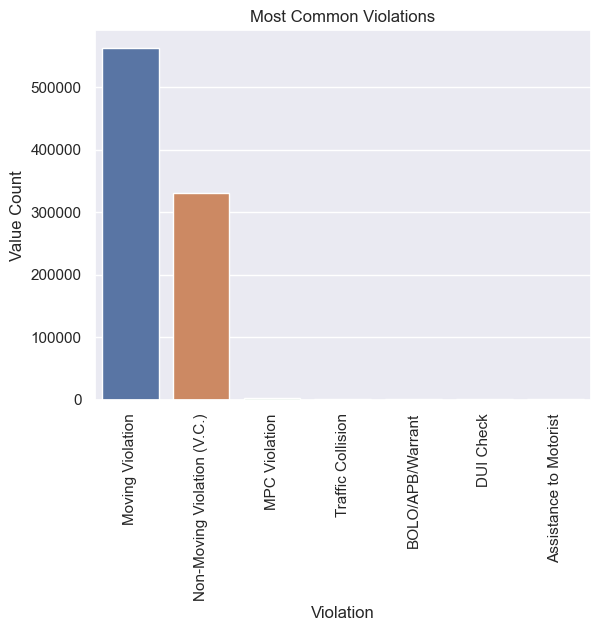

In [25]:
sns.countplot(x = 'violation', data = df, order = df.violation.value_counts().index)
plt.xlabel("Violation")
plt.xticks(rotation = 90)
plt.ylabel("Value Count")
plt.title("Most Common Violations")
plt.show()

## Most Common Outcomes

In [26]:
df.outcome.value_counts()

citation      631045
warning       244787
Not Stated     15191
arrest         11540
Name: outcome, dtype: int64

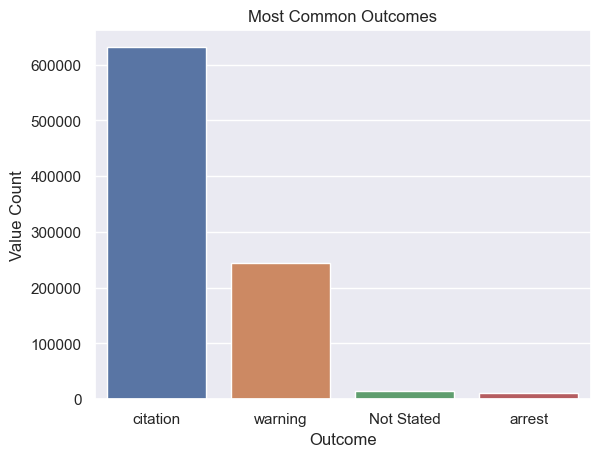

In [27]:
sns.countplot(x = 'outcome', data = df, order = df.outcome.value_counts().index)
plt.xlabel("Outcome")
plt.ylabel("Value Count")
plt.title("Most Common Outcomes")
plt.show()

## Most Stopped Race

In [28]:
df.race.value_counts(normalize = True) * 100 

white       41.188150
asian       17.451967
black       16.739995
hispanic    12.801101
other       11.818787
Name: race, dtype: float64

In [29]:
df.race.value_counts()

white       371749
asian       157515
black       151089
hispanic    115538
other       106672
Name: race, dtype: int64

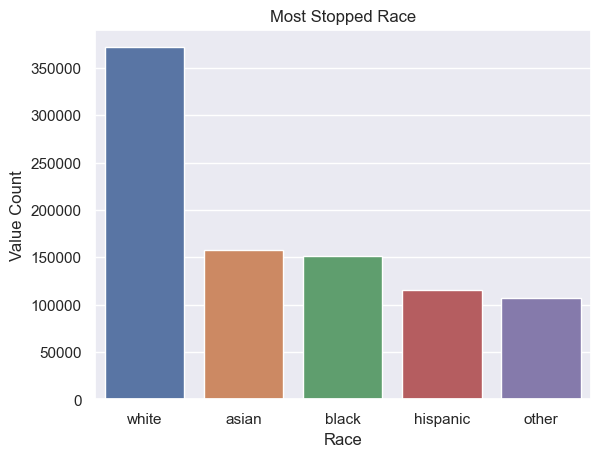

In [30]:
#plt.xkcd() # to use the xkcd style
sns.countplot(x = 'race', data = df, order = df.race.value_counts().index)
plt.xlabel("Race")
plt.ylabel("Value Count")
plt.title("Most Stopped Race")
plt.show()

## Most stopped Gender

In [31]:
df.gender.value_counts(normalize = True) * 100

male      70.591637
female    29.408363
Name: gender, dtype: float64

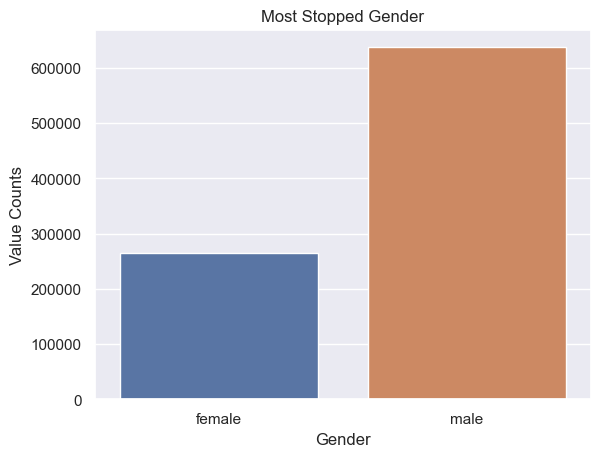

In [32]:
sns.countplot(x = 'gender', data = df)
plt.xlabel("Gender")
plt.ylabel("Value Counts")
plt.title("Most Stopped Gender")
plt.show()
plt.show()

### Number of Offenders Based on Race and Gender

In [33]:
pd.crosstab(df.race, df.gender)

gender,female,male
race,,
asian,47837,109678
black,44901,106188
hispanic,26652,88886
other,22328,84344
white,123711,248038


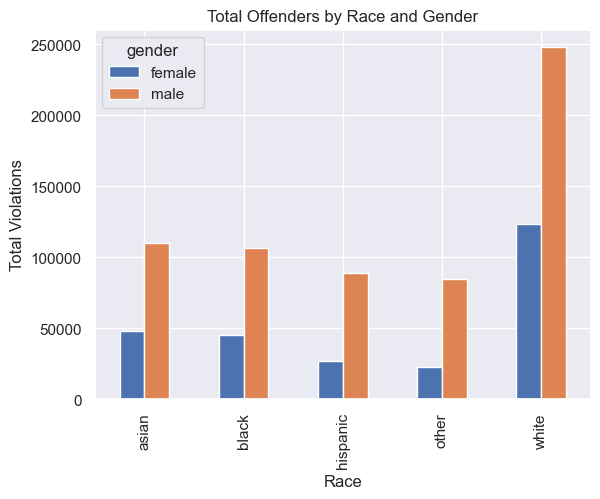

In [34]:
gender_vs_race_table = pd.crosstab(df.race, df.gender)
gender_vs_race_table.plot(kind = "bar")
plt.xlabel('Race')
plt.ylabel('Total Violations')
plt.title("Total Offenders by Race and Gender")
plt.show()

## Outcome based on the race of offenders

In [35]:
outcome_by_race = pd.crosstab(df.race, df.outcome)
print(outcome_by_race)

outcome   Not Stated  arrest  citation  warning
race                                           
asian            930    1201    123406    31978
black           4052    3342     83476    60219
hispanic        4865    2224     77239    31210
other           1643     889     81383    22757
white           3701    3884    265541    98623


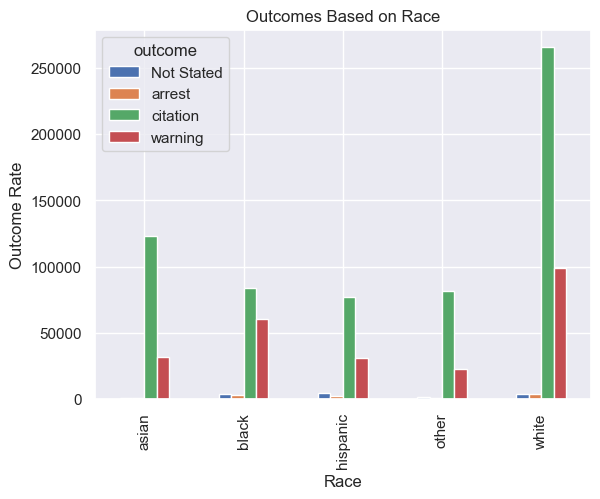

In [36]:
outcome_by_race.plot(kind = 'bar')
plt.xlabel('Race')
plt.ylabel('Outcome Rate')
plt.title("Outcomes Based on Race")
plt.show()

## Outcomes based on gender of offenders

In [37]:
outcome_by_gender = pd.crosstab(df.gender, df.outcome)
print(outcome_by_gender)

outcome  Not Stated  arrest  citation  warning
gender                                        
female         3089    2449    187586    72305
male          12102    9091    443459   172482


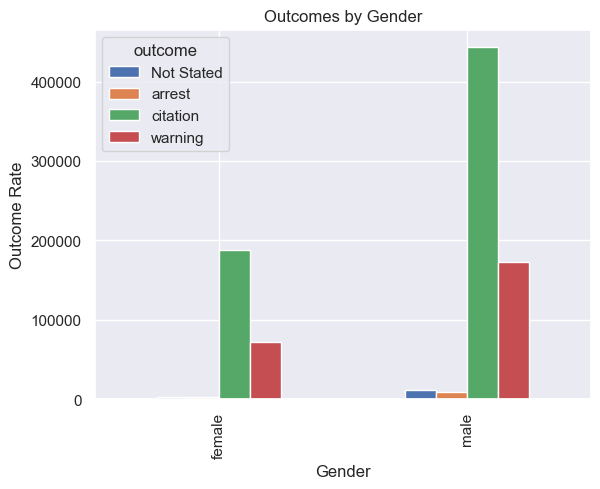

In [38]:
outcome_by_gender.plot(kind = 'bar')
plt.xlabel('Gender')
plt.ylabel('Outcome Rate')
plt.title("Outcomes by Gender")
plt.show()

## Violations based on gender

In [39]:
violations_by_gender = pd.crosstab(df.gender, df.violation)
violations_by_gender

violation,Assistance to Motorist,BOLO/APB/Warrant,DUI Check,MPC Violation,Moving Violation,Non-Moving Violation (V.C.),Traffic Collision
gender,,,,,,,
female,202,246,255,336,167099,96863,428
male,728,961,782,3206,395964,234578,915


## Violations based on race

In [40]:
violations_by_race = pd.crosstab(df.race, df.violation)
violations_by_race

violation,Assistance to Motorist,BOLO/APB/Warrant,DUI Check,MPC Violation,Moving Violation,Non-Moving Violation (V.C.),Traffic Collision
race,,,,,,,
asian,92,66,135,255,103350,53363,254
black,240,646,188,930,75444,73472,169
hispanic,178,201,211,556,67000,47080,312
other,91,86,108,797,73102,32355,133
white,329,208,395,1004,244167,125171,475


## Arrest rate by time of the day

In [41]:
hourly_arrest_rate = df.groupby(df.index.hour).arrest_made.sum()
hourly_arrest_rate

datetime
0     739
1     457
2     382
3     164
4     109
5      73
6      77
7     192
8     348
9     395
10    393
11    453
12    481
13    535
14    523
15    461
16    606
17    776
18    739
19    677
20    590
21    560
22    861
23    949
Name: arrest_made, dtype: int64

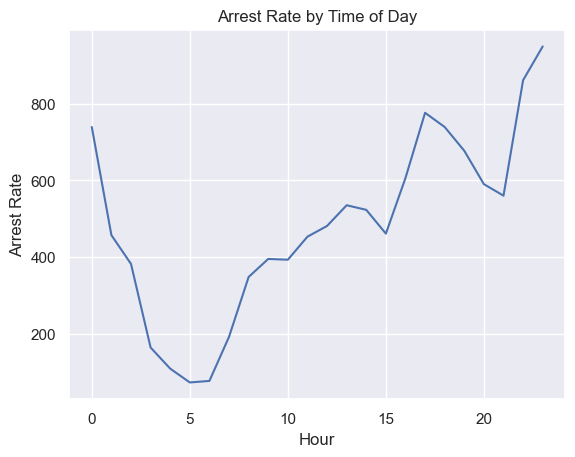

In [42]:
# Create a line plot of 'hourly_arrest_rate
hourly_arrest_rate.plot()
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title("Arrest Rate by Time of Day")
plt.show()

### Total Arrests Made per Year

In [43]:
# Calculating the overall arrest rate
print(df.arrest_made.sum())
# Total Arrests by Year
yearly_arrest_rate = df.groupby(df.index.year).arrest_made.sum()
yearly_arrest_rate

11540


datetime
2007    2146
2008    2066
2009    1586
2010    1485
2011    1056
2012     674
2013     583
2014     702
2015     868
2016     374
Name: arrest_made, dtype: int64

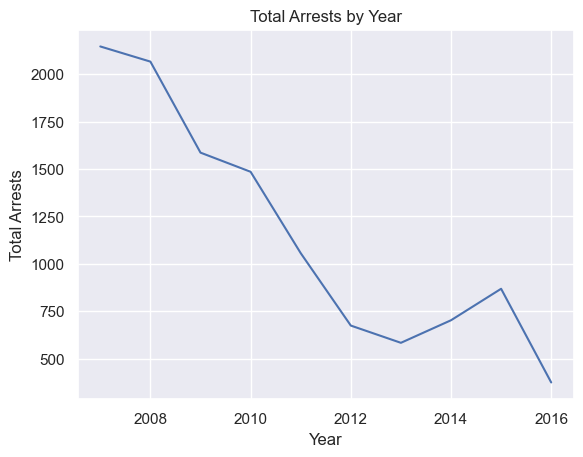

In [44]:
yearly_arrest_rate.plot()
plt.xlabel("Year")
plt.ylabel("Total Arrests")
plt.title("Total Arrests by Year")
plt.show()

## Violations by time of day

In [45]:
# Calculating the overall stoppage rate
print(df.violation.count())
# Hourly stop rate
hourly_stop_rate = df.groupby(df.index.hour).violation.count()
hourly_stop_rate

902563


datetime
0     43399
1     24009
2     15031
3      8758
4      8062
5      8470
6      7089
7     24752
8     41984
9     42305
10    41408
11    41484
12    44158
13    44829
14    45945
15    39354
16    50805
17    62524
18    56185
19    48723
20    36363
21    39013
22    64773
23    63140
Name: violation, dtype: int64

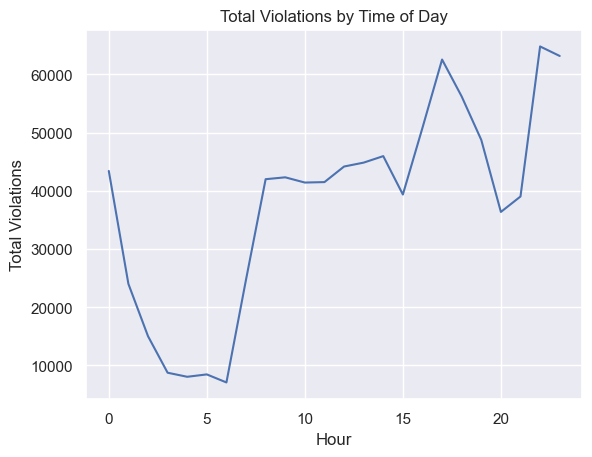

In [46]:
hourly_stop_rate.plot()
plt.xlabel("Hour")
plt.ylabel("Total Violations")
plt.title("Total Violations by Time of Day")
plt.show()

## Total Stoppage by Year

In [47]:
# To calculate and Save the hourly arrest rate
yearly_stop_rate = df.groupby(df.index.year).violation.count()
yearly_stop_rate

datetime
2007    101984
2008    112941
2009    110475
2010    104620
2011     99291
2012     82117
2013     73881
2014     91550
2015     85560
2016     40144
Name: violation, dtype: int64

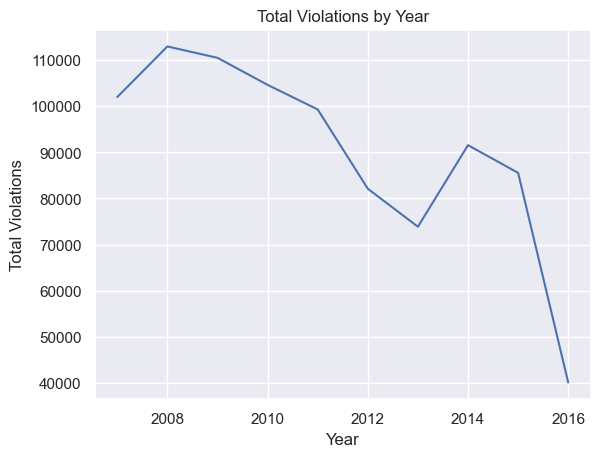

In [48]:
yearly_stop_rate.plot()
plt.xlabel("Year")
plt.ylabel("Total Violations")
plt.title("Total Violations by Year")
plt.show()

## Total Violations Commited by age groups

In [49]:
# Describing the subject age column. This shows the minimum and maximum age and other statistical data
df.subject_age.describe().T

count    902563.000000
mean         37.830349
std          13.184425
min          10.000000
25%          27.000000
50%          37.000000
75%          46.000000
max         100.000000
Name: subject_age, dtype: float64

In [50]:
age_violation_count = df.groupby("subject_age")['violation'].count()
age_violation_count.sort_values()

subject_age
98.000000         2
11.000000         3
100.000000        4
97.000000         4
96.000000         5
95.000000         6
12.000000         9
10.000000        10
13.000000        13
94.000000        13
93.000000        13
14.000000        32
99.000000        34
91.000000        42
92.000000        45
15.000000        84
90.000000        90
89.000000       107
88.000000       135
87.000000       174
86.000000       221
84.000000       284
85.000000       304
83.000000       320
82.000000       451
81.000000       477
79.000000       675
16.000000       680
80.000000       719
78.000000       816
77.000000       822
76.000000       938
74.000000      1249
75.000000      1320
73.000000      1421
72.000000      1642
71.000000      1701
69.000000      2320
17.000000      2584
70.000000      2592
68.000000      2758
67.000000      3294
66.000000      3575
64.000000      4850
65.000000      5352
63.000000      5435
61.000000      6451
62.000000      6498
59.000000      7777
58.00000

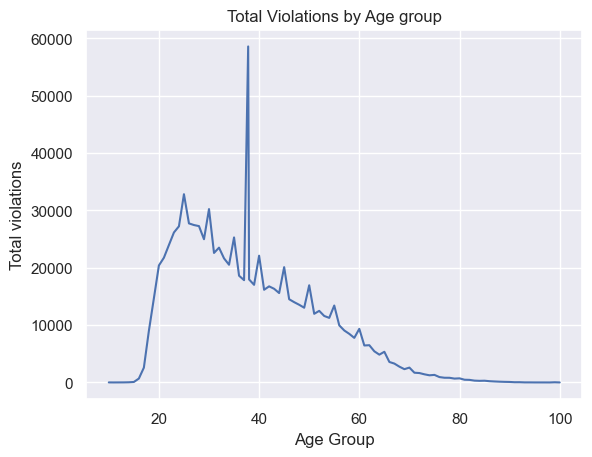

In [51]:
age_violation_count.plot()
plt.xlabel("Age Group")
plt.ylabel("Total violations")
plt.title("Total Violations by Age group")
plt.show()

# Observations

## The following were observed from the data exploration

- The most common violations were moving violation and Mechanical or non-moving violation with 62.4% and 36.7% respectively. Other forms of violation constituted a minute portion of the total percentage. 
- Citation (69.9%) was the most common outcome, followed by warning (27.1), only very few offenders (1.2%) were arrested.
- The white race were the top traffic offenders in san francisco with 41.2%, followed by Asian with 17.5%, black and hispanic constituted 16.7% and 12.8% respectively. 
- Male traffic offenders were far greater than female offenders.
- There are more tarffic offenders at night than during the daytime.
- The youth between age 20 and 40 commited more traffic violations than other age groups.
- 2008 was the year with the highest violation rate.

### Thanks for Reading.